# Análise de Dados do Mercado Imobiliário

Objetivo do Projeto

Realizar uma análise exploratória em uma base de dados de aluguéis residenciais. O objetivo é limpar os dados brutos, remover inconsistências (como imóveis comerciais misturados com residenciais), tratar valores nulos e criar novas métricas para auxiliar na tomada de decisão de valores de aluguel.

1. Coleta e Inspeção Inicial dos Dados:
Nesta etapa, importo as bibliotecas necessárias e carrego o dataset para entender a estrutura das variáveis (tipos de dados, quantidade de linhas e colunas).

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Configuração para visualização
%matplotlib inline

# Carregamento dos dados
url = 'https://raw.githubusercontent.com/alura-cursos/pandas-conhecendo-a-biblioteca/main/base-de-dados/aluguel.csv'
dados = pd.read_csv(url, sep=';')

# Inspeção inicial: Primeiras linhas e tipos de dados
print(f"Dimensões do dataset: {dados.shape}")
display(dados.head())
dados.info()

Dimensões do dataset: (32960, 9)


,Tipo,Bairro,Quartos,Vagas,Suites,Area,Valor,Condominio,IPTU
0,Quitinete,Copacabana,1,0,0,40,1700.0,500.0,60.0
1,Casa,Jardim Botânico,2,0,1,100,7000.0,NaN,NaN
2,Conjunto Comercial/Sala,Barra da Tijuca,0,4,0,150,5200.0,4020.0,1111.0
3,Apartamento,Centro,1,0,0,15,800.0,390.0,20.0
4,Apartamento,Higienópolis,1,0,0,48,800.0,230.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32960 entries, 0 to 32959
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tipo        32960 non-null  object 
 1   Bairro      32960 non-null  object 
 2   Quartos     32960 non-null  int64  
 3   Vagas       32960 non-null  int64  
 4   Suites      32960 non-null  int64  
 5   Area        32960 non-null  int64  
 6   Valor       32943 non-null  float64
 7   Condominio  28867 non-null  float64
 8   IPTU        22723 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 2.3+ MB


2. Análise Exploratória: Valor Médio por Tipo
Antes de limpar os dados, faço uma análise rápida para entender como os preços se comportam por categoria. Isso ajuda a identificar anomalias (ex: aluguéis comerciais distorcendo a média).

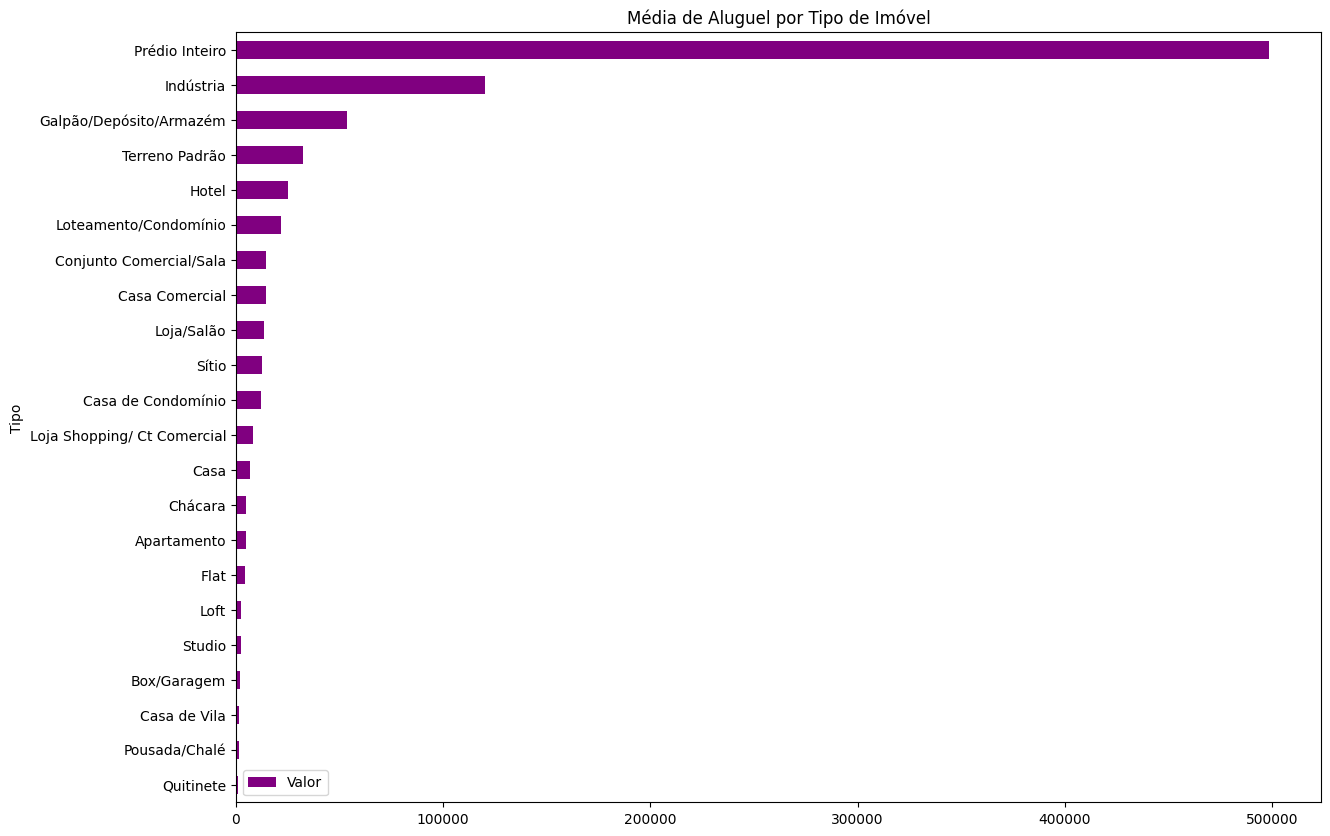

In [24]:
# Calculando a média de valor por tipo de imóvel
df_preco_tipo = dados.groupby('Tipo')[['Valor']].mean().sort_values('Valor')

# Visualização gráfica para identificar disparidades
df_preco_tipo.plot(kind='barh', figsize=(14, 10), color='purple', title='Média de Aluguel por Tipo de Imóvel')
plt.show()

3. Limpeza de Dados (Data Cleaning)

3.1 Remoção de Imóveis Comerciais Estratégia: Como o foco da análise é o mercado residencial, notei que a base continha lojas, galpões e conjuntos comerciais que distorcem a análise de preço. Decidi criar um filtro para remover essas categorias.

In [25]:
# Lista de tipos de imóveis comerciais identificados na base
imoveis_comerciais = [
    'Conjunto Comercial/Sala', 'Prédio Inteiro', 'Loja/Salão',
    'Galpão/Depósito/Armazém', 'Casa Comercial', 'Terreno Padrão',
    'Loja Shopping/ Ct Comercial', 'Box/Garagem', 'Chácara',
    'Loteamento/Condomínio', 'Sítio', 'Pousada/Chalé', 'Hotel', 'Indústria'
]

# Filtrando apenas os imóveis que NÃO estão na lista comercial
df_residencial = dados.query('@imoveis_comerciais not in Tipo')

# Verificando os tipos restantes
print("Tipos de imóveis restantes após a limpeza:")
print(df_residencial['Tipo'].unique())

Tipos de imóveis restantes após a limpeza:
['Quitinete' 'Casa' 'Apartamento' 'Casa de Condomínio' 'Flat'
 'Casa de Vila' 'Loft' 'Studio']


3.2 Foco no segmento "Apartamentos"
Estratégia: Para esta etapa específica do projeto, decidi nichar a análise apenas para Apartamentos, que representam a maior fatia do mercado urbano.

In [26]:
# Verificando a representatividade dos apartamentos
percentual_tipo = df_residencial['Tipo'].value_counts(normalize=True)
print(percentual_tipo)

# Filtrando apenas apartamentos
df_apartamentos = df_residencial.query('Tipo == "Apartamento"').copy() # .copy() para evitar SettingWithCopyWarning
display(df_apartamentos.head())

Tipo
Apartamento           0.845139
Casa de Condomínio    0.043096
Casa                  0.041842
Quitinete             0.036173
Flat                  0.020596
Casa de Vila          0.010774
Loft                  0.002207
Studio                0.000173
Name: proportion, dtype: float64


,Tipo,Bairro,Quartos,Vagas,Suites,Area,Valor,Condominio,IPTU
3,Apartamento,Centro,1,0,0,15,800.0,390.0,20.0
4,Apartamento,Higienópolis,1,0,0,48,800.0,230.0,NaN
5,Apartamento,Vista Alegre,3,1,0,70,1200.0,NaN,NaN
6,Apartamento,Cachambi,2,0,0,50,1300.0,301.0,17.0
10,Apartamento,Centro,1,0,0,36,1200.0,NaN,NaN


3.3 Tratamento de Dados Nulos (NaN) e Inconsistentes
Estratégia:

1. Valores de Valor ou Condominio zerados ou nulos invalidam o cálculo de custo mensal. Decidi remover registros onde o aluguel ou condomínio são 0 ou nulos.

2. Para IPTU, assumi que valores nulos significam isenção, portanto preenchi com 0.

In [27]:
print("Dados nulos antes do tratamento:")
print(df_apartamentos.isnull().sum())

# Tratando IPTU (Nulo = Isento)
df_apartamentos['IPTU'] = df_apartamentos['IPTU'].fillna(0)

# Tratando Condomínio (Nulo = 0 para posterior remoção ou ajuste)
df_apartamentos['Condominio'] = df_apartamentos['Condominio'].fillna(0)

# Removendo registros onde Valor ou Condomínio são 0 (dados inconsistentes para análise de receita)
registros_a_remover = df_apartamentos.query('Valor == 0 | Condominio == 0').index
df_apartamentos.drop(registros_a_remover, axis=0, inplace=True)

# Removendo registros onde Valor é nulo (NaN)
df_apartamentos.dropna(subset=['Valor'], inplace=True)

print("\nDados nulos/inválidos após tratamento (deve ser zero):")
print(df_apartamentos.isnull().sum())

Dados nulos antes do tratamento:
Tipo             0
Bairro           0
Quartos          0
Vagas            0
Suites           0
Area             0
Valor            7
Condominio     745
IPTU          5472
dtype: int64

Dados nulos/inválidos após tratamento (deve ser zero):
Tipo          0
Bairro        0
Quartos       0
Vagas         0
Suites        0
Area          0
Valor         0
Condominio    0
IPTU          0
dtype: int64


4. Feature Engineering (Criação de Variáveis):
Para enriquecer a análise, criei novas colunas que agregam valor para o usuário final, como o custo total mensal e descrições textuais.

In [28]:
# 1. Valor Mensal (Aluguel + Condomínio)
df_apartamentos['Valor_por_mes'] = df_apartamentos['Valor'] + df_apartamentos['Condominio']

# 2. Valor Anual (Mensal * 12 + IPTU)
df_apartamentos['Valor_por_ano'] = (df_apartamentos['Valor_por_mes'] * 12) + df_apartamentos['IPTU']

# 3. Coluna descritiva para facilitar leitura ou exportação de relatórios
df_apartamentos['Descricao'] = (
    df_apartamentos['Tipo'] + ' em ' + df_apartamentos['Bairro'] +
    ' com ' + df_apartamentos['Quartos'].astype(str) + ' quarto(s) e ' +
    df_apartamentos['Vagas'].astype(str) + ' vaga(s) de garagem.'
)

# 4. Coluna binária para Suites (Facilita filtros futuros)
df_apartamentos['Possui_suite'] = df_apartamentos['Suites'].apply(lambda x: "Sim" if x > 0 else "Não")

display(df_apartamentos.head())

,Tipo,Bairro,Quartos,Vagas,Suites,Area,Valor,Condominio,IPTU,Valor_por_mes,Valor_por_ano,Descricao,Possui_suite
3,Apartamento,Centro,1,0,0,15,800.0,390.0,20.0,1190.0,14300.0,Apartamento em Centro com 1 quarto(s) e 0 vaga...,Não
4,Apartamento,Higienópolis,1,0,0,48,800.0,230.0,0.0,1030.0,12360.0,Apartamento em Higienópolis com 1 quarto(s) e ...,Não
6,Apartamento,Cachambi,2,0,0,50,1300.0,301.0,17.0,1601.0,19229.0,Apartamento em Cachambi com 2 quarto(s) e 0 va...,Não
11,Apartamento,Grajaú,2,1,0,70,1500.0,642.0,74.0,2142.0,25778.0,Apartamento em Grajaú com 2 quarto(s) e 1 vaga...,Não
12,Apartamento,Lins de Vasconcelos,3,1,1,90,1500.0,455.0,14.0,1955.0,23474.0,Apartamento em Lins de Vasconcelos com 3 quart...,Sim


5. Insights e Filtros Estratégicos:
Realizei filtros específicos para responder a perguntas de negócio comuns, como "Onde encontrar imóveis baratos?" ou "Opções para família".

Cenário 1: Imóveis econômicos para solteiros/casais

*   1 Quarto
*   Aluguel abaixo de R$ 1.200,00

In [29]:
selecao_economica = (df_apartamentos['Quartos'] == 1) & (df_apartamentos['Valor'] < 1200)
df_economico = df_apartamentos[selecao_economica]

print(f"Encontrados {df_economico.shape[0]} imóveis no perfil econômico.")
display(df_economico.head())

Encontrados 499 imóveis no perfil econômico.


,Tipo,Bairro,Quartos,Vagas,Suites,Area,Valor,Condominio,IPTU,Valor_por_mes,Valor_por_ano,Descricao,Possui_suite
3,Apartamento,Centro,1,0,0,15,800.0,390.0,20.0,1190.0,14300.0,Apartamento em Centro com 1 quarto(s) e 0 vaga...,Não
4,Apartamento,Higienópolis,1,0,0,48,800.0,230.0,0.0,1030.0,12360.0,Apartamento em Higienópolis com 1 quarto(s) e ...,Não
28,Apartamento,Tijuca,1,0,0,48,750.0,772.0,25.0,1522.0,18289.0,Apartamento em Tijuca com 1 quarto(s) e 0 vaga...,Não
54,Apartamento,Centro,1,0,0,27,750.0,371.0,19.0,1121.0,13471.0,Apartamento em Centro com 1 quarto(s) e 0 vaga...,Não
94,Apartamento,Centro,1,1,0,37,1100.0,540.0,900.0,1640.0,20580.0,Apartamento em Centro com 1 quarto(s) e 1 vaga...,Não


Cenário 2: Imóveis familiares médios

*   Pelo menos 2 quartos
*   Aluguel até R$ 3.000,00
*   Área maior que 70m²





In [30]:
selecao_familia = (df_apartamentos['Quartos'] >= 2) & (df_apartamentos['Valor'] < 3000) & (df_apartamentos['Area'] > 70)
df_familia = df_apartamentos[selecao_familia]

print(f"Encontrados {df_familia.shape[0]} imóveis no perfil familiar.")
display(df_familia.head())

Encontrados 4459 imóveis no perfil familiar.


,Tipo,Bairro,Quartos,Vagas,Suites,Area,Valor,Condominio,IPTU,Valor_por_mes,Valor_por_ano,Descricao,Possui_suite
12,Apartamento,Lins de Vasconcelos,3,1,1,90,1500.0,455.0,14.0,1955.0,23474.0,Apartamento em Lins de Vasconcelos com 3 quart...,Sim
21,Apartamento,Tijuca,2,1,0,110,1900.0,700.0,138.0,2600.0,31338.0,Apartamento em Tijuca com 2 quarto(s) e 1 vaga...,Não
24,Apartamento,Tijuca,2,1,0,78,2000.0,700.0,0.0,2700.0,32400.0,Apartamento em Tijuca com 2 quarto(s) e 1 vaga...,Não
32,Apartamento,Botafogo,2,1,0,76,2500.0,740.0,0.0,3240.0,38880.0,Apartamento em Botafogo com 2 quarto(s) e 1 va...,Não
36,Apartamento,Recreio dos Bandeirantes,3,1,1,105,2300.0,648.0,0.0,2948.0,35376.0,Apartamento em Recreio dos Bandeirantes com 3 ...,Sim


6. Conclusão e Exportação:
Os dados foram limpos, transformados e enriquecidos. A base final está pronta para ser utilizada em dashboards (Power BI/Tableau) ou modelos de Machine Learning.

In [31]:
# Exportando a base limpa e tratada
df_apartamentos.to_csv('dados_apartamentos_limpos.csv', index=False, sep=';')
print("Arquivo exportado com sucesso.")

Arquivo exportado com sucesso.
